# Convolutional Neural Network (CNN)

### Imports

In [333]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [334]:
import numpy as np 
import pandas as pd 
#from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from glob import glob
import os
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.model_selection import train_test_split

### General settings


In [335]:
log_dir = "logs/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


### Load the dataset and format data

In [336]:
bishop = glob('data/Bishop/*.jpg')
king = glob('data/Bishop/*.jpg')
knight = glob('data/Bishop/*.jpg')
pawn = glob('data/Bishop/*.jpg')
queen = glob('data/Bishop/*.jpg')
rook = glob('data/rook/*.jpg')


In [337]:
# stats a bout the Data

print(f'in total there are {len(bishop) + len(king) + len(knight) + len(pawn) + len(queen) + len(rook)} images')
print(f'bishop: {len(bishop)}')
print(f'king: {len(king)}')
print(f'knight: {len(knight)}')
print(f'pawn: {len(pawn)}')
print(f'queen: {len(queen)}')
print(f'rook: {len(rook)}')


in total there are 442 images
bishop: 71
king: 71
knight: 71
pawn: 71
queen: 71
rook: 87


{'king': 76, 'queen': 78, 'bishop': 87, 'rook': 102, 'knight': 106, 'pawn': 107}


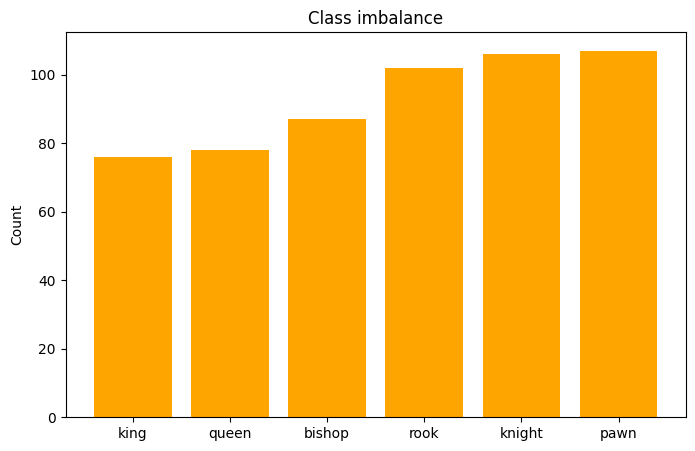

In [338]:
labels = ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']
label_counts = dict()
for class_label in labels:
  label_counts[class_label] = len(os.listdir(f'data/{class_label}/'))

label_counts = dict(sorted(label_counts.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(list(label_counts.keys()), list(label_counts.values()), color ='orange')
plt.xlabel('') 
plt.ylabel('Count') 
ax.set_xticks(list(label_counts.keys()))
plt.title('Class imbalance') 

print(label_counts)

plt.show()

In [339]:
models_accuracy = dict()

In [340]:
def extract_class_weights():
    class_names = ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']
    
    class_counts = dict()
    for name in class_names:
        class_counts[name] = len(os.listdir('data/' + name))
    
    total = sum(class_counts.values())
    num_classes = len(class_names)
    
    class_weights = dict()
    for i in range(num_classes):
        class_weights[i] = total / (num_classes * list(class_counts.values())[i])
        print('{} {}: {:.2}'.format(i+1, class_names[i], class_weights[i]))
        
    return class_weights

extract_class_weights()

1 bishop: 1.1
2 king: 1.2
3 knight: 0.87
4 pawn: 0.87
5 queen: 1.2
6 rook: 0.91


{0: 1.0651340996168583,
 1: 1.219298245614035,
 2: 0.8742138364779874,
 3: 0.8660436137071651,
 4: 1.188034188034188,
 5: 0.9084967320261438}

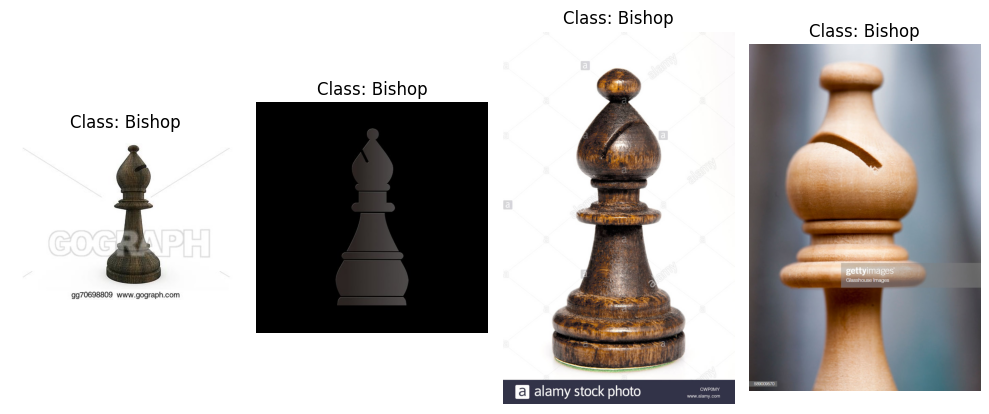

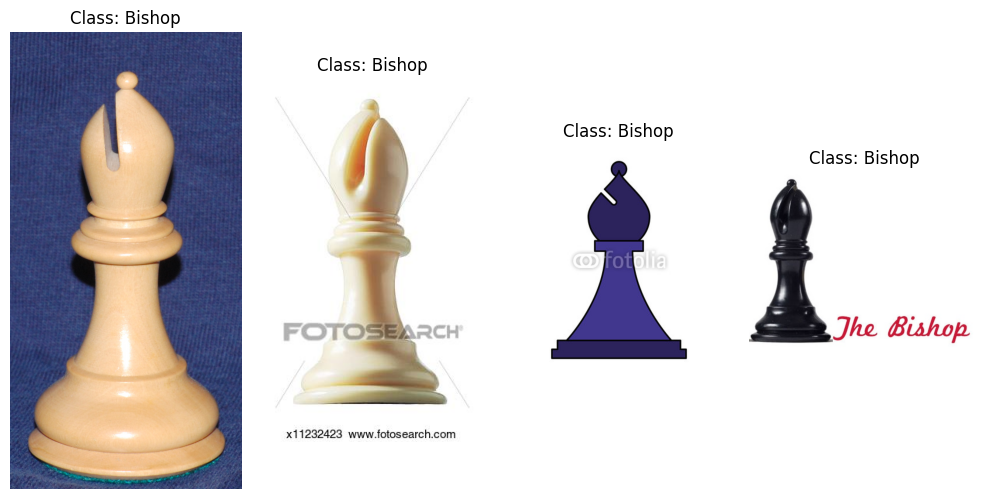

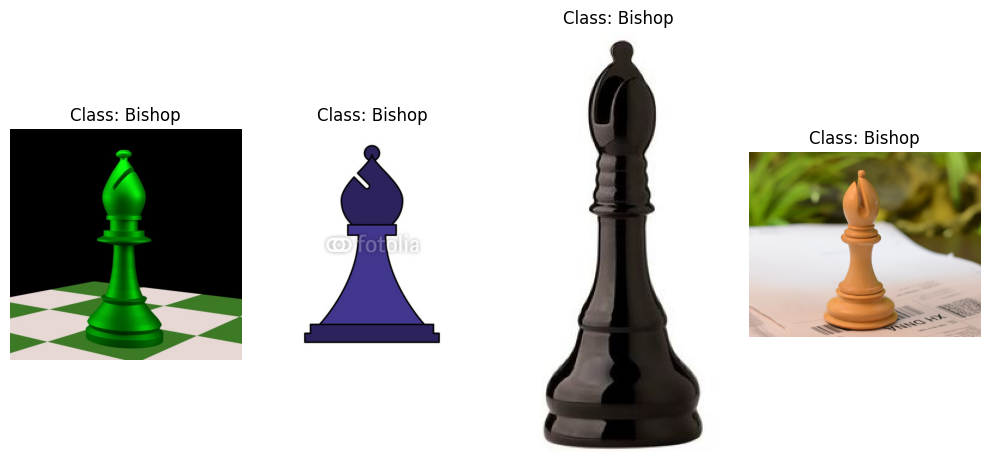

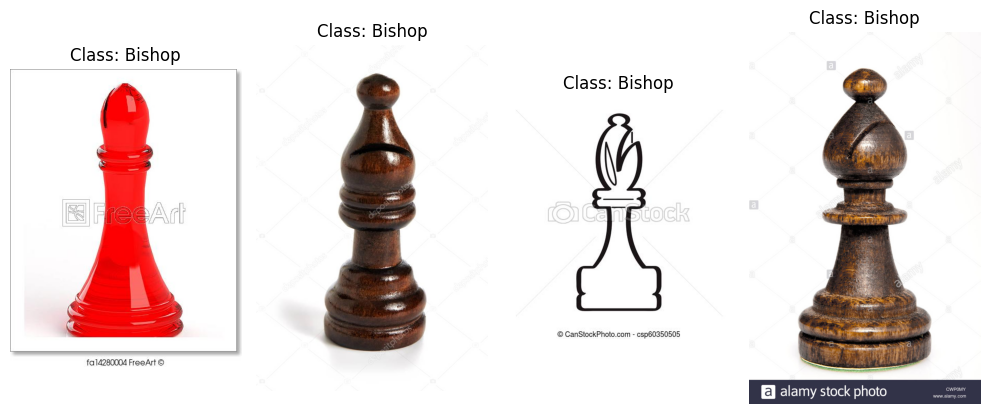

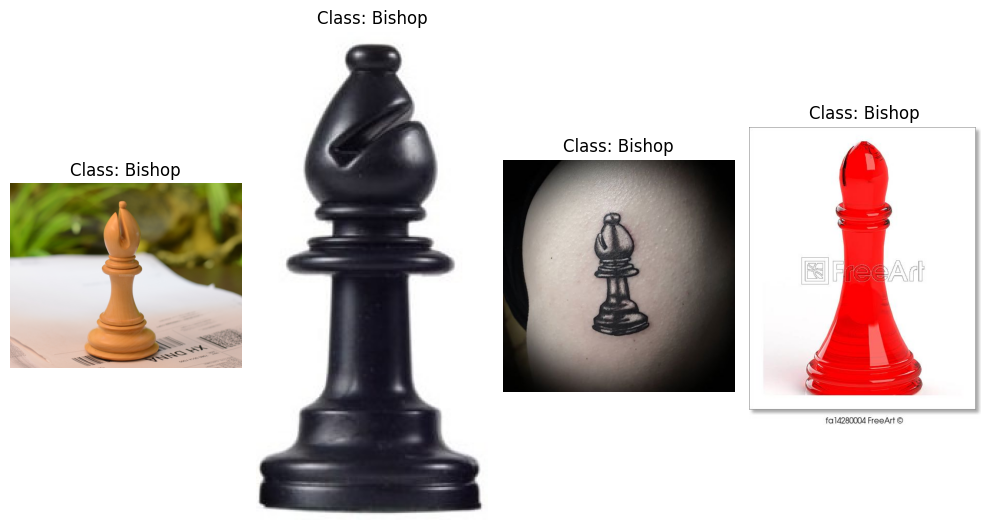

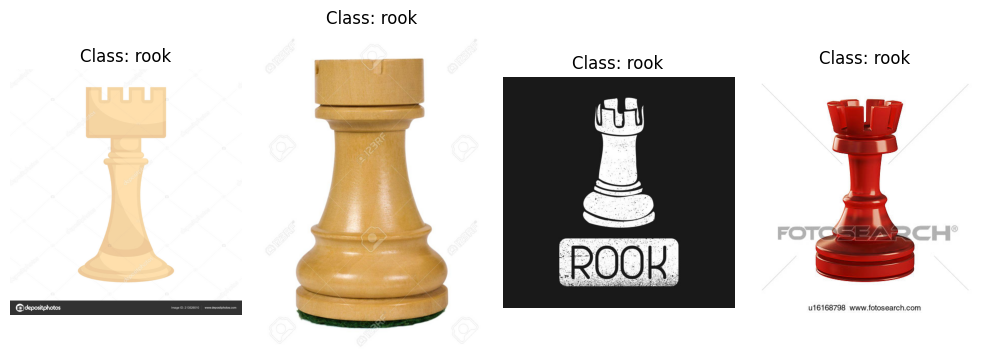

In [341]:

def display_images(label):
    import random
    from matplotlib.image import imread
    from pathlib import PurePath
    
    fig, axs = plt.subplots(1, 4, figsize=(10, 6), tight_layout=True)
    axs = axs.ravel()
    

    img_list = random.sample(label, 4)
    
    for i, img_path in enumerate(img_list):
        img = imread(img_path)
        label = PurePath(img_path).parent.name
        axs[i].set_title(f'Class: {label}', fontsize=12)
        axs[i].imshow(img, cmap='magma')
        axs[i].axis('off')
    plt.show()
    
display_images(bishop)
display_images(king)
display_images(knight)
display_images(pawn)
display_images(queen)
display_images(rook)

In [342]:
import numpy as np

resized_image_array = []
resized_image_array_label = []

SIZE = 32

def resize_images(image_directory):
    from PIL import Image
    
    target_size = (SIZE, SIZE)
    
    for file in image_directory:
        img = Image.open(file)

        img = img.convert('L')
        
        img = img.resize(target_size)
        array_temp = np.array(img)
        
        shape_new = SIZE * SIZE
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        
        if image_directory == bishop:
            resized_image_array_label.append(0)
        elif image_directory == king:
            resized_image_array_label.append(1)
        elif image_directory == knight:
            resized_image_array_label.append(2)
        elif image_directory == pawn:
            resized_image_array_label.append(3)
        elif image_directory == queen:
            resized_image_array_label.append(4)
        elif image_directory == rook:
            resized_image_array_label.append(5)
            
resize_images(bishop)
resize_images(king)
resize_images(knight)
resize_images(pawn)
resize_images(queen)
resize_images(rook)



In [343]:


train_images, temp_images, train_labels, temp_labels = train_test_split(
    resized_image_array, resized_image_array_label, test_size=0.3, shuffle=True, random_state=7)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, shuffle=True, random_state=7)

train_images = np.array(train_images).reshape(-1, SIZE, SIZE, 1)
val_images = np.array(val_images).reshape(-1, SIZE, SIZE, 1)
test_images = np.array(test_images).reshape(-1, SIZE, SIZE, 1)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")


Training set size: 309
Validation set size: 66
Test set size: 67


### Initialize model and set parameters

In [344]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(48, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [345]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 30, 30, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 4, 4, 48)       │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,278 (266.71 KB)

 Trainable params: 68,278 (266.71 KB)

 Non-trainable params: 0 (0.00 B)

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [346]:
import tensorflow as tf



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)



history = model.fit(train_images, train_labels, epochs=40,
                    validation_data=(val_images, val_labels), callbacks=[tensorboard_callback, early_stopping])

model.save('chess_piece_classifier.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6171 - loss: 5.2792 - val_accuracy: 0.6667 - val_loss: 0.7676
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7330 - loss: 0.6407 - val_accuracy: 0.7879 - val_loss: 0.5714
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8631 - loss: 0.3443 - val_accuracy: 0.8030 - val_loss: 0.5198
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9164 - loss: 0.2475 - val_accuracy: 0.8636 - val_loss: 0.4411
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9463 - loss: 0.1617 - val_accuracy: 0.8788 - val_loss: 0.4592
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9242 - loss: 0.1963 - val_accuracy: 0.8485 - val_loss: 0.4852
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9514 - loss: 0.1399 - val_accuracy: 0.8485 - val_loss: 0.4674
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9674 - loss: 0.1263 - val_accuracy: 0.8485 - v

3/3 - 0s - 6ms/step - accuracy: 0.8657 - loss: 0.3334

Test accuracy: 0.8656716346740723


### Evaluate the model

3/3 - 0s - 8ms/step - accuracy: 0.8657 - loss: 0.3334


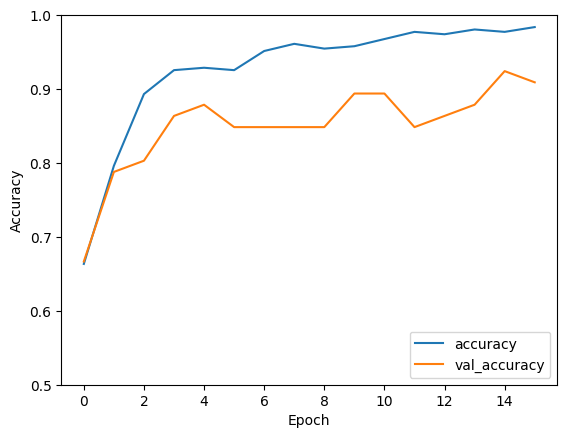

In [347]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.